# XPECTO Epidemic 2.0 Competition Evaluation

This notebook provides a standardized environment for evaluating your epidemic control strategy for the XPECTO competition. 

## Competition Rules and Requirements

To ensure a fair competition, all submissions must adhere to the following requirements:

1. **Player Registration**: You must register with your real name and email
2. **Strategy Definition**: Your strategy must be defined as a function that accepts an engine parameter
3. **Tampering Prevention**: All runs are logged with timestamps, environment information, and strategy code
4. **Run Duration**: Official submissions must use the full 365-day simulation duration
5. **Scenario Accuracy**: You must use the official competition scenarios without modifications
6. **Attempt Limits**: You have a maximum of 3 official attempts per scenario

## Submission Process

After evaluating and testing your strategy, you should:

1. Run a final official attempt with `is_practice=False`
2. Save the generated submission file to include with your competition entry
3. The submission file will include your strategy code, results, and verification data

Let's begin by importing the necessary modules and setting up the evaluation environment.

In [1]:
%matplotlib inline
import sys
import os
import json
import inspect
import platform
import hashlib
import uuid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
from IPython.display import display, HTML

# Add parent directory to path to allow importing from src
sys.path.append('..')

# Import competition modules
from src.competition.testing.enhanced_engine import EnhancedEngine
from src.competition.competition_manager import CompetitionManager
from src.competition.evaluation.strategy_evaluator import StrategyEvaluator
from src.competition.evaluation.visualization import EvaluationVisualizer

# Setup paths
SUBMISSION_DIR = Path('../notebooks/competition_submissions')
SUBMISSION_DIR.mkdir(exist_ok=True, parents=True)

# Print environment information for verification
print(f"Python Version: {platform.python_version()}")
print(f"Operating System: {platform.system()} {platform.release()}")
print(f"Evaluation Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Testing mode enabled: EngineV1 replaced with MockEngine
Python Version: 3.10.12
Operating System: Linux 6.8.0-52-generic
Evaluation Time: 2025-03-30 15:50:38


## Player Registration

Please enter your real name and email address. This information will be used to track your submissions and notify you of competition results.

In [2]:
# Player information - please use your real name and email
PLAYER_NAME = "Your Name"
PLAYER_EMAIL = "your.email@example.com"  # Optional but recommended

# Initialize the competition system
engine = EnhancedEngine()
competition = CompetitionManager(data_dir="../practice_data", engine=engine)

# Register player
player_id = competition.setup_player(name=PLAYER_NAME, email=PLAYER_EMAIL)
print(f"Player registered: {PLAYER_NAME} (ID: {player_id})")

# By default, we start in practice mode
competition.toggle_practice_mode(is_practice=True)
print("Practice mode enabled - attempts will not count toward your official score")

Player registered: Your Name (ID: ce725186-6440-4feb-ac23-709325c51cce)
Player registered: Your Name (ID: ce725186-6440-4feb-ac23-709325c51cce)
Mode set to: Practice
Practice mode enabled - attempts will not count toward your official score


## Available Scenarios

The competition includes several scenarios of varying difficulty. You can test your strategy against any of these scenarios. For official submissions, your strategy will be evaluated on all scenarios.

In [3]:
# List available scenarios
scenarios = competition.list_available_scenarios()

# Display scenarios in a more readable format
for i, scenario in enumerate(scenarios):
    print(f"Scenario {i+1}: {scenario['name']} (ID: {scenario['id']})")
    print(f"  Difficulty: {scenario['difficulty']}")
    print(f"  R0: {scenario['r0']}")
    print(f"  Initial Resources: {scenario['initial_resources']}")
    print("")

# Select a scenario for evaluation
SELECTED_SCENARIO = "standard"  # Change this to test different scenarios
competition.set_scenario(SELECTED_SCENARIO)
print(f"Selected scenario: {SELECTED_SCENARIO}")

,ID,Name,Difficulty,R0,Resources
0,standard,Standard Outbreak,standard,2.5,1000
1,challenging,Challenging Outbreak,challenging,3.5,700


Scenario 1: Standard Outbreak (ID: standard)
  Difficulty: standard
  R0: 2.5
  Initial Resources: 1000

Scenario 2: Challenging Outbreak (ID: challenging)
  Difficulty: challenging
  R0: 3.5
  Initial Resources: 700

Current scenario set to: Standard Outbreak (standard)
Selected scenario: standard


## Define Your Strategy

Now, define your epidemic control strategy function. This should be a function that takes an `engine` parameter and applies your strategy using the engine's intervention methods.

Your strategy function can include:
1. Initial resource allocation and lockdown settings
2. Callback functions for adaptive response
3. Logic based on the current state of the simulation

The example below shows a basic strategy. Replace it with your own strategy implementation.

In [4]:
def my_strategy(engine):
    """
    My competition strategy for epidemic control.
    
    Parameters:
    -----------
    engine : EnhancedEngine
        The simulation engine instance
    """
    # Initial settings
    engine.set_lockdown_level(0.5)  # 50% lockdown
    engine.allocate_resources('healthcare', 400)  # Allocate 400 resources to healthcare
    engine.allocate_resources('economy', 300)  # Allocate 300 resources to economy support
    engine.allocate_resources('research', 300)  # Allocate 300 resources to research
    
    # Define a callback function for adaptive response
    def adaptive_response(step, state):
        # Ensure we never divide by zero (total population might be zero in extreme cases)
        total_population = max(1, state.population.total)
        infection_rate = state.population.infected / total_population
        
        # Adjust lockdown based on infection rate
        if infection_rate > 0.15:
            # Severe outbreak - increase lockdown
            engine.set_lockdown_level(0.8)
            engine.allocate_resources('healthcare', 600)
            engine.allocate_resources('economy', 200)
            engine.allocate_resources('research', 200)
        elif infection_rate > 0.05:
            # Moderate outbreak - balanced approach
            engine.set_lockdown_level(0.5)
            engine.allocate_resources('healthcare', 400)
            engine.allocate_resources('economy', 300)
            engine.allocate_resources('research', 300)
        else:
            # Controlled situation - focus on economy
            engine.set_lockdown_level(0.3)
            engine.allocate_resources('healthcare', 200)
            engine.allocate_resources('economy', 500)
            engine.allocate_resources('research', 300)
    
    # Register the callback function for step-by-step adaptation
    engine.register_step_callback(adaptive_response)

# Get the source code of the strategy for logging
strategy_source = inspect.getsource(my_strategy)
print("Strategy defined.")

Strategy defined.


## Test Run in Practice Mode

Let's run a practice simulation with your strategy to see how it performs. This won't count toward your official attempts.

In [5]:
# Make sure we're in practice mode
competition.toggle_practice_mode(is_practice=True)

# Setup the simulation
competition.setup_simulation()

# Run the simulation with your strategy
print("Running simulation in practice mode...")
practice_results = competition.run_simulation(
    steps=365,  # Full year simulation
    interventions=[my_strategy]
)

# Display results
print("\nSimulation Results:")
print(f"Final Score: {practice_results.get('final_score', 0):.4f}")
print(f"Population Survived: {practice_results.get('population_survived', 0):.1%}")
print(f"GDP Preserved: {practice_results.get('gdp_preserved', 0):.1%}")
print(f"Infection Control: {practice_results.get('infection_control', 0):.1%}")
print(f"Resource Efficiency: {practice_results.get('resource_efficiency', 0):.1%}")
print(f"Time to Containment: {practice_results.get('time_to_containment', 0)} days")

Mode set to: Practice
Scenario 'Standard Outbreak' configured with slight variations:
  - R0: 2.49 (base: 2.5)
  - Initial infections: 107 across regions (base: 100)
  - Resources: 990 (base: 1000)
Simulation configured for scenario: Standard Outbreak
Running simulation in practice mode...

=== Active Disease Variants ===
Gamma Variant:
  Prevalence: 100.0%
  Transmissibility: 1.7x base
  Severity: 1.2x base
  Immune Escape: 50.0%

Beta Variant:
  Prevalence: 99.1%
  Transmissibility: 1.3x base
  Severity: 1.3x base
  Immune Escape: 30.0%

Alpha Variant:
  Prevalence: 98.9%
  Transmissibility: 1.5x base
  Severity: 1.1x base
  Immune Escape: 10.0%


=== Strategy Performance Analysis ===
Score: 0.0195   (Raw: 0.0224)
Grade: F

Key Performance Indicators:
  Population Survival: 0.0%
  Economic Preservation: 0.1%
  Infection Control: 0.0%
  Multi-Objective Balance: 0.000

Variants: Gamma, Beta, Alpha (peak: 100.0%)
Variant Response Rating: 0.24

Strategy Rating: Critical Failure
Strategy 

## In-depth Strategy Analysis

Now let's use the evaluation module to get a more detailed analysis of your strategy's performance.

Performing detailed strategy analysis...

=== Active Disease Variants ===
Beta Variant:
  Prevalence: 100.0%
  Transmissibility: 1.3x base
  Severity: 1.3x base
  Immune Escape: 30.0%

Alpha Variant:
  Prevalence: 100.0%
  Transmissibility: 1.5x base
  Severity: 1.1x base
  Immune Escape: 10.0%

Gamma Variant:
  Prevalence: 100.0%
  Transmissibility: 1.7x base
  Severity: 1.2x base
  Immune Escape: 50.0%


=== Strategy Performance Analysis ===
Score: 0.0000   (Raw: 0.0217)
Grade: F

Key Performance Indicators:
  Population Survival: 0.0%
  Economic Preservation: 0.1%
  Infection Control: 0.0%
  Multi-Objective Balance: 0.000

Variants: Beta, Alpha, Gamma (peak: 100.0%)
Variant Response Rating: 0.23

Strategy Rating: Critical Failure
Strategy Archetype: Healthcare-Focused
Resource Distribution: Healthcare 58%, Economy 0%, Research 21%

STRENGTHS:
  None identified

WEAKNESSES:
  - Poor population protection
  - Weak economic management
  - Insufficient infection control
  - Inefficient 

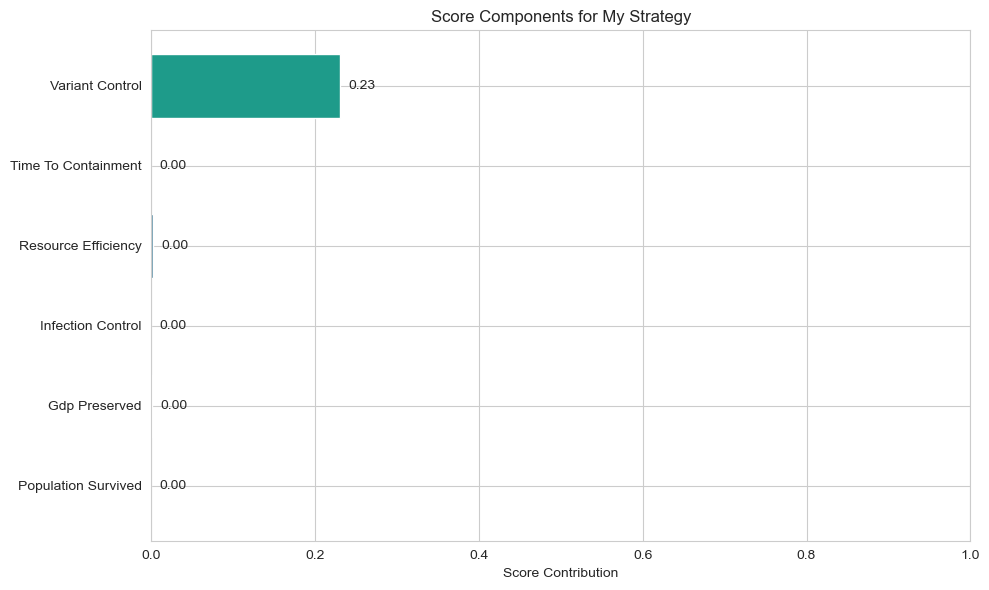

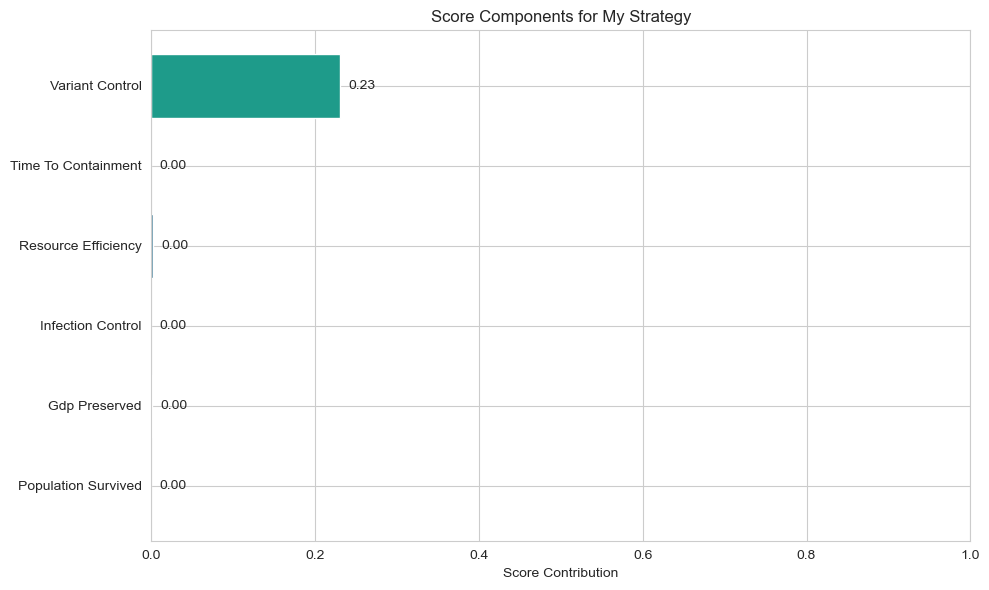

In [6]:
# Create strategy evaluator
evaluator = StrategyEvaluator()
visualizer = EvaluationVisualizer(evaluator)

# Evaluate your strategy
print("Performing detailed strategy analysis...")
evaluation = evaluator.evaluate_strategy(
    name="My Strategy",
    strategy=my_strategy,
    steps=365,  # Full year simulation
    num_trials=1  # Just one run for this analysis
)

# Display evaluation results with grade
print(f"\nStrategy Evaluation Results:")
print(f"Score: {evaluation.score:.4f} (Grade: {evaluation.grade})")
print(f"Population Survived: {evaluation.population_survived:.1%}")
print(f"GDP Preserved: {evaluation.gdp_preserved:.1%}")
print(f"Infection Control: {evaluation.infection_control:.1%}")
print(f"Resource Efficiency: {evaluation.resource_efficiency:.1%}")
print(f"Time to Containment: {evaluation.time_to_containment} days")

if evaluation.variant_control is not None:
    print(f"Variant Control: {evaluation.variant_control:.2f}")

# Generate a score breakdown visualization
breakdown_fig = visualizer.plot_score_breakdown("My Strategy")
display(breakdown_fig)

## Performance Metrics Over Time

Let's visualize how key metrics change over the course of the simulation.

Note: If visualizations don't appear, make sure you've run the cell at the beginning of this notebook with `%matplotlib inline`. This ensures plots display properly in the notebook.

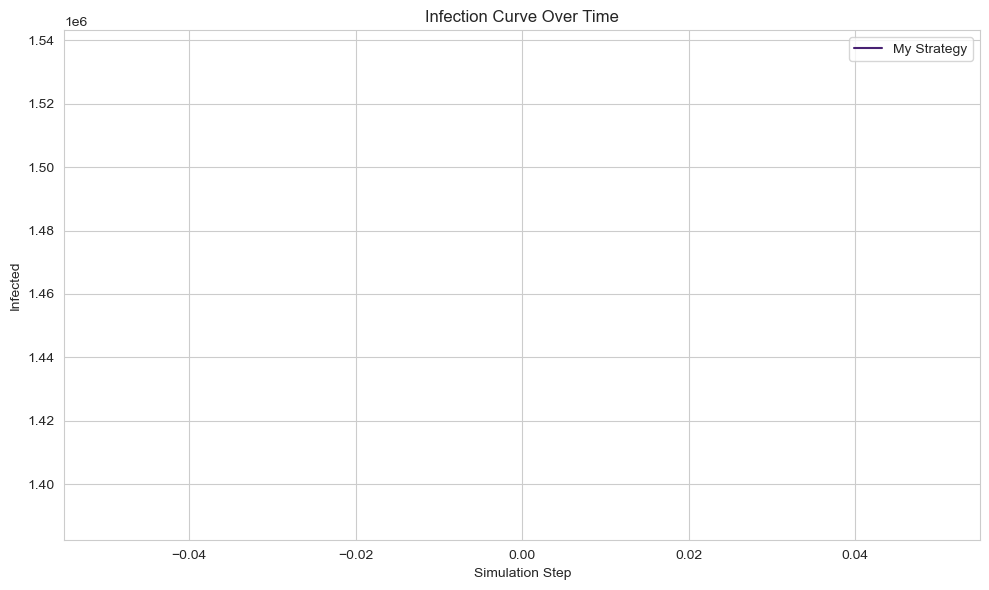

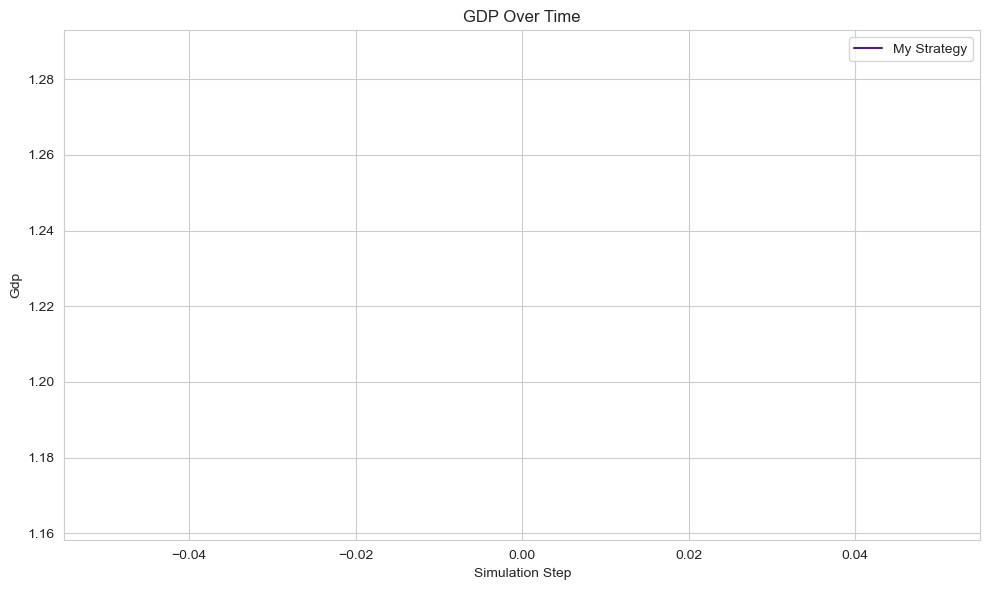

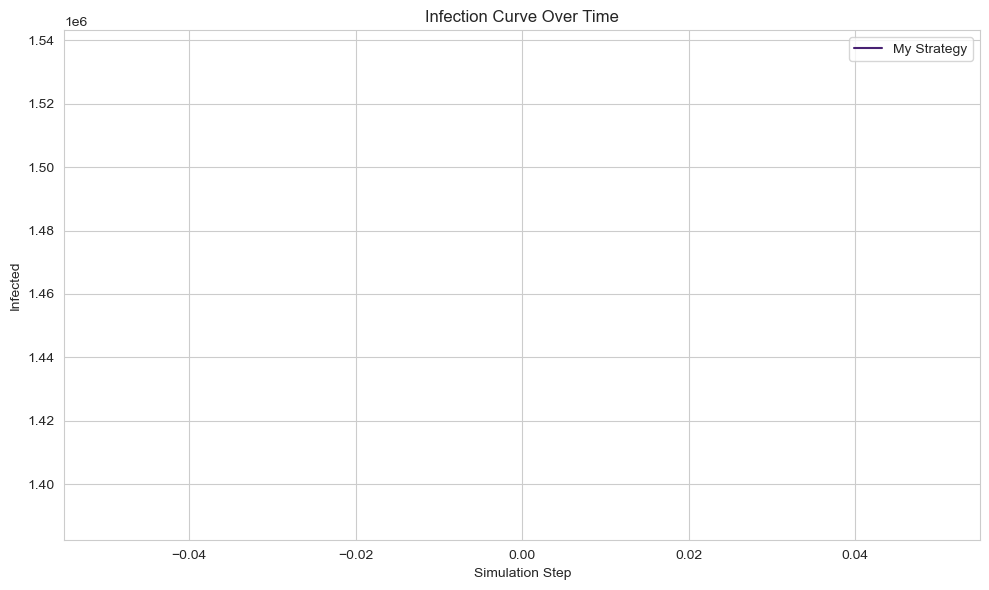

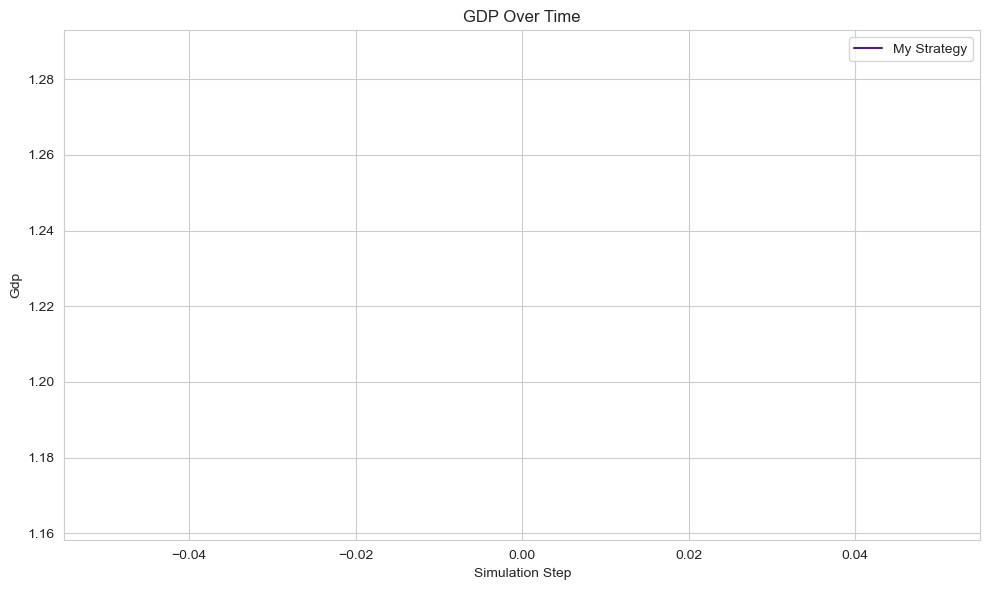

In [7]:
# Plot infection curve
fig1 = visualizer.plot_metric_over_time(
    strategies=["My Strategy"],
    metric="infected",
    title="Infection Curve Over Time"
)
display(fig1)  # Explicitly display the figure

# Plot economic impact
fig2 = visualizer.plot_metric_over_time(
    strategies=["My Strategy"],
    metric="gdp",
    title="GDP Over Time"
)
display(fig2)  # Explicitly display the figure

## Compare Multiple Strategies (Optional)

If you want to compare different versions of your strategy, you can define additional strategies and evaluate them together.


=== Active Disease Variants ===
Gamma Variant:
  Prevalence: 100.0%
  Transmissibility: 1.7x base
  Severity: 1.2x base
  Immune Escape: 50.0%

Beta Variant:
  Prevalence: 100.0%
  Transmissibility: 1.3x base
  Severity: 1.3x base
  Immune Escape: 30.0%

Alpha Variant:
  Prevalence: 98.6%
  Transmissibility: 1.5x base
  Severity: 1.1x base
  Immune Escape: 10.0%


=== Strategy Performance Analysis ===
Score: 0.0055   (Raw: 0.0222)
Grade: F

Key Performance Indicators:
  Population Survival: 0.0%
  Economic Preservation: 0.1%
  Infection Control: 0.0%
  Multi-Objective Balance: 0.000

Variants: Gamma, Beta, Alpha (peak: 100.0%)
Variant Response Rating: 0.23

Strategy Rating: Critical Failure
Strategy Archetype: Healthcare-Focused
Resource Distribution: Healthcare 59%, Economy 0%, Research 20%

STRENGTHS:
  None identified

WEAKNESSES:
  - Poor population protection
  - Weak economic management
  - Insufficient infection control
  - Inefficient resource allocation

RECOMMENDATIONS:
  → 

,Strategy,Score,Grade,Population,GDP,Infection Control,Resource Efficiency
1,Alternative Strategy,0.696777,B,100.0%,70.5%,0.0%,11.2%
0,My Strategy,0.005545,F,0.0%,0.1%,0.0%,0.2%


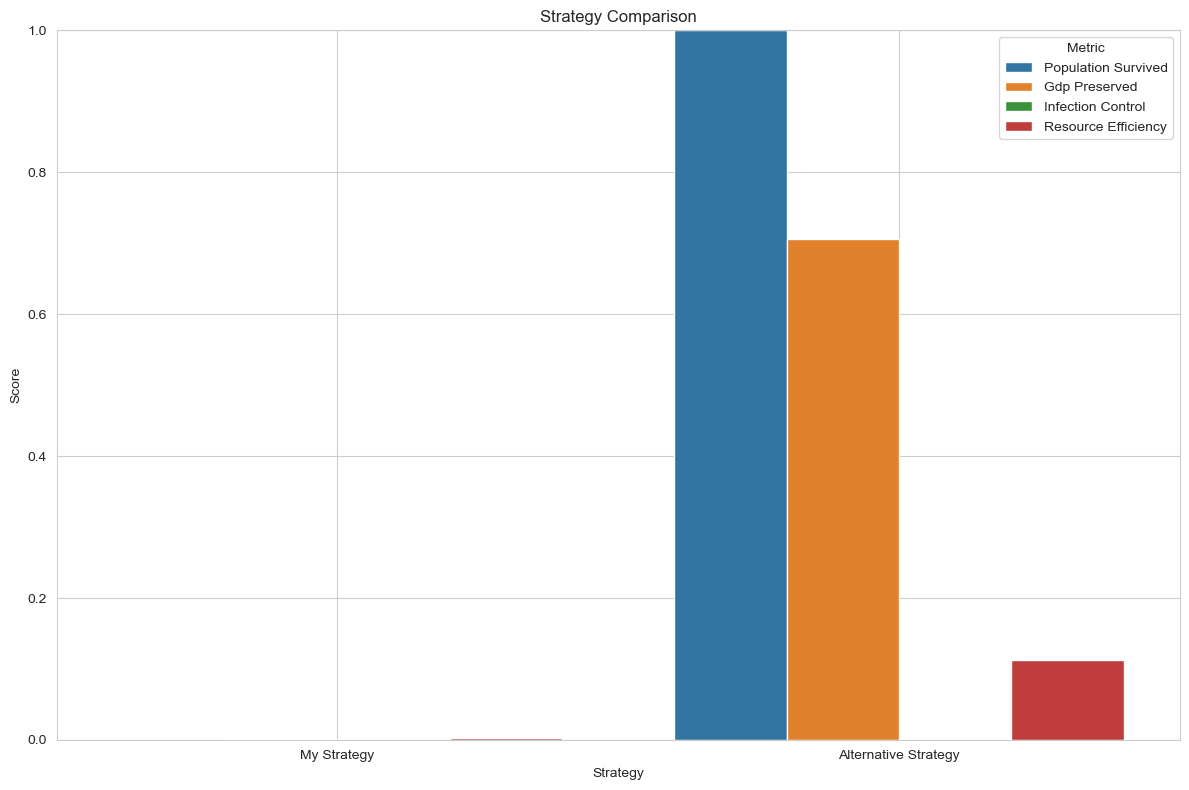

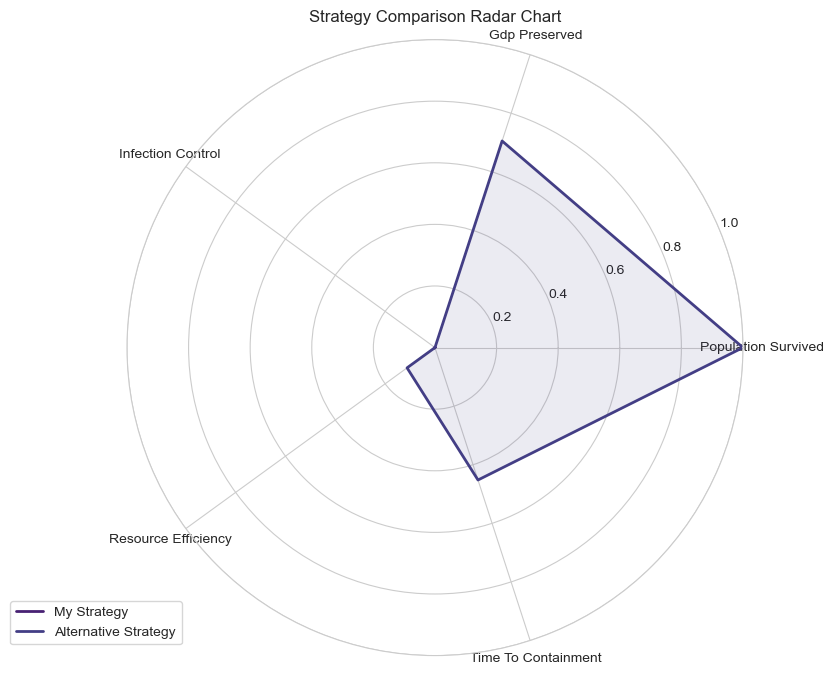

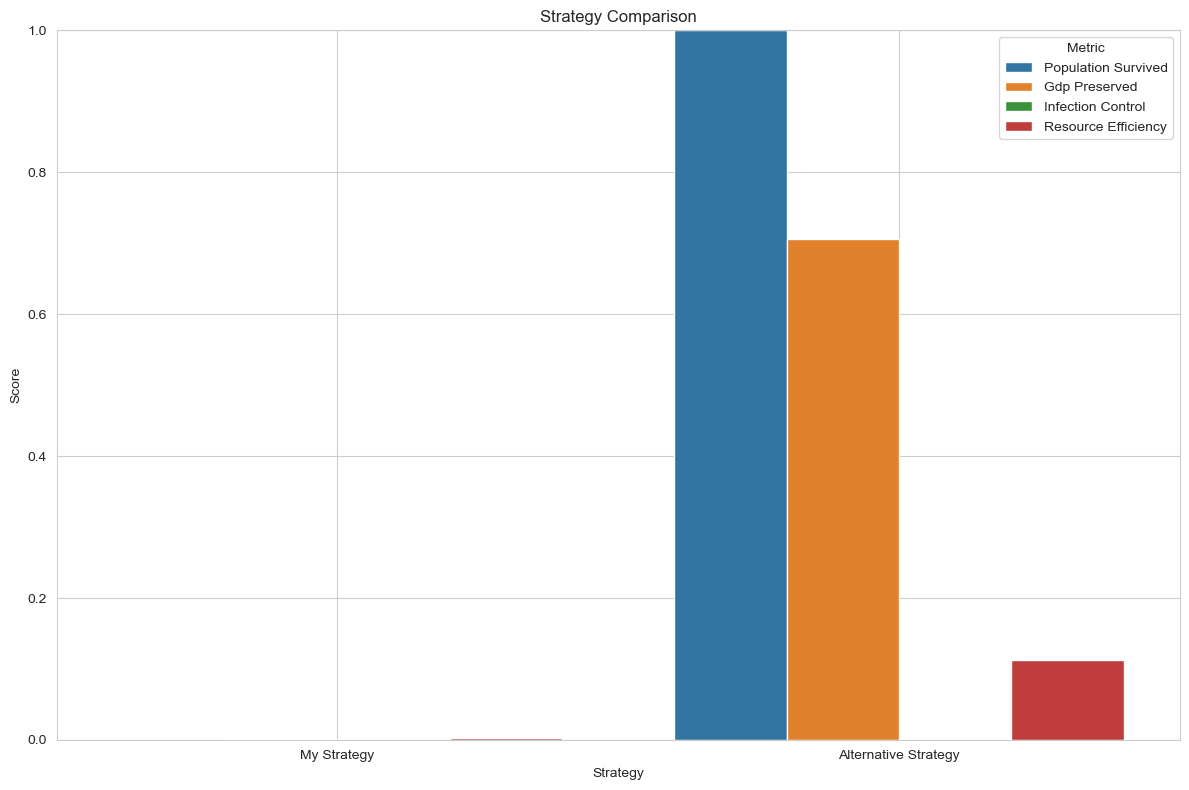

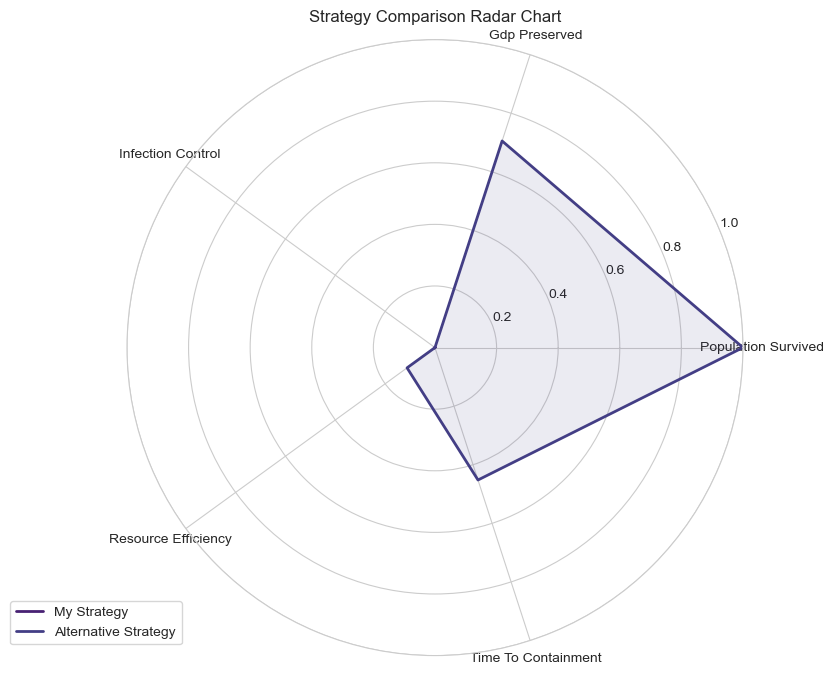

In [8]:
# Example alternative strategy for comparison
def alternative_strategy(engine):
    """A different approach to compare against"""
    # Higher initial lockdown, more focus on healthcare
    engine.set_lockdown_level(0.7)
    engine.allocate_resources('healthcare', 600)
    engine.allocate_resources('economy', 200)
    engine.allocate_resources('research', 200)
    
    def adaptive_response(step, state):
        total_population = max(1, state.population.total)
        infection_rate = state.population.infected / total_population
        
        if infection_rate < 0.03:
            engine.set_lockdown_level(0.4)
            engine.allocate_resources('economy', 400)
            engine.allocate_resources('healthcare', 300)
    
    engine.register_step_callback(adaptive_response)

# Compare strategies (optional)
strategies = {
    "My Strategy": my_strategy,
    "Alternative Strategy": alternative_strategy
}

comparison_df = evaluator.compare_strategies(
    strategies=strategies,
    steps=365,
    num_trials=1
)

print("Strategy Comparison:")
display(comparison_df)

# Plot comparison
comparison_fig = visualizer.plot_strategy_comparison()
display(comparison_fig)

# Create radar chart comparison
radar_fig = visualizer.plot_radar_chart(list(strategies.keys()))
display(radar_fig)

## Creating Official Submission

When you're satisfied with your strategy's performance, you can create an official submission. This will count toward your limit of 3 official attempts per scenario.

**Important:** Check your remaining attempts before proceeding.

In [9]:
# Check remaining official attempts
remaining_attempts = competition.get_remaining_attempts()
print(f"Remaining official attempts for scenario '{SELECTED_SCENARIO}': {remaining_attempts}")

# Add a warning if this is the last attempt
if remaining_attempts <= 1:
    print("⚠️ WARNING: This is your last official attempt for this scenario!")

Remaining official attempts for scenario 'standard': 3


If you want to proceed with an official submission, run the next cell. This will:
1. Switch to official mode (not practice)
2. Run your strategy on the selected scenario
3. Save all results and verification data to a submission file

**Note:** Only run this when you're ready to submit your final strategy!

In [10]:
# Function to create submission with verification data
def create_official_submission(strategy_func, scenario_id):
    # Collect environment data
    environment_data = {
        "timestamp": datetime.now().isoformat(),
        "python_version": platform.python_version(),
        "os": f"{platform.system()} {platform.release()}",
        "player_id": competition.current_player_id,
        "player_name": PLAYER_NAME,
        "scenario_id": scenario_id,
        "submission_id": str(uuid.uuid4())
    }
    
    # Get strategy source code
    strategy_source = inspect.getsource(strategy_func)
    
    # Create strategy hash for verification
    strategy_hash = hashlib.sha256(strategy_source.encode()).hexdigest()
    
    # Toggle to official mode
    competition.toggle_practice_mode(is_practice=False)
    print("Switched to OFFICIAL mode - this attempt will count!")
    
    # Setup and run simulation
    competition.setup_simulation()
    
    # Record start time
    start_time = datetime.now()
    
    # Run simulation with the strategy
    print(f"Running official simulation for scenario '{scenario_id}'...")
    results = competition.run_simulation(
        steps=365,  # Full year is required for official submission
        interventions=[strategy_func]
    )
    
    # Record end time and duration
    end_time = datetime.now()
    duration = (end_time - start_time).total_seconds()
    
    # Create submission file
    submission_data = {
        "environment": environment_data,
        "strategy": {
            "name": strategy_func.__name__,
            "source": strategy_source,
            "hash": strategy_hash
        },
        "execution": {
            "start_time": start_time.isoformat(),
            "end_time": end_time.isoformat(),
            "duration_seconds": duration
        },
        "results": results
    }
    
    # Generate a unique filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{PLAYER_NAME.replace(' ', '_')}_{scenario_id}_{timestamp}.json"
    filepath = SUBMISSION_DIR / filename
    
    # Save submission file
    with open(filepath, 'w') as f:
        json.dump(submission_data, f, indent=2)
    
    # Switch back to practice mode
    competition.toggle_practice_mode(is_practice=True)
    print("Switched back to practice mode")
    
    return filepath, results

# Uncomment and run the following line when you're ready to create an official submission
# submission_file, official_results = create_official_submission(my_strategy, SELECTED_SCENARIO)

## Submission Verification

After creating an official submission, you should verify that your submission file contains all the required information.

In [11]:
# Function to verify a submission file
def verify_submission_file(filepath):
    try:
        with open(filepath, 'r') as f:
            submission = json.load(f)
        
        # Check essential components
        required_sections = ['environment', 'strategy', 'execution', 'results']
        missing_sections = [s for s in required_sections if s not in submission]
        
        if missing_sections:
            print(f"❌ ERROR: Missing required sections: {', '.join(missing_sections)}")
            return False
        
        # Verify strategy hash matches the source
        strategy_source = submission['strategy']['source']
        computed_hash = hashlib.sha256(strategy_source.encode()).hexdigest()
        
        if computed_hash != submission['strategy']['hash']:
            print("❌ ERROR: Strategy hash doesn't match the source code - possible tampering")
            return False
        
        # Check for required results fields
        required_results = ['final_score', 'population_survived', 'gdp_preserved']
        missing_results = [r for r in required_results if r not in submission['results']]
        
        if missing_results:
            print(f"❌ ERROR: Missing required result fields: {', '.join(missing_results)}")
            return False
        
        # All checks passed
        print("✅ Submission file successfully verified!")
        print(f"📊 Final Score: {submission['results']['final_score']:.4f}")
        print(f"👨‍👩‍👧‍👦 Population Survived: {submission['results']['population_survived']:.1%}")
        print(f"💰 GDP Preserved: {submission['results']['gdp_preserved']:.1%}")
        print(f"🔬 Infection Control: {submission['results']['infection_control']:.1%}")
        print(f"⏱️ Execution Duration: {submission['execution']['duration_seconds']:.2f} seconds")
        print(f"⏰ Submission Timestamp: {submission['environment']['timestamp']}")
        
        return True
    except Exception as e:
        print(f"❌ ERROR: Failed to verify submission file: {e}")
        return False

# Uncomment and run after creating a submission
# is_valid = verify_submission_file(submission_file)

## Competition Submission Instructions

To officially submit your strategy to the competition:

1. Create your official submission by running the `create_official_submission` function
2. Verify your submission file is valid by running the `verify_submission_file` function
3. Submit both your notebook file (`*.ipynb`) and the generated JSON submission file

Remember that you have a maximum of 3 official attempts per scenario. Choose wisely when to make your official submissions.

### Fairness and Anti-Tampering Measures

Each submission includes the following verification data:

- **Timestamps**: When the simulation was run
- **Environment**: Python version and OS information
- **Strategy Code**: Full source code of your strategy function
- **Strategy Hash**: SHA-256 hash of your strategy code for integrity verification
- **Player Information**: Your registered player ID and name
- **Execution Metrics**: Start time, end time, and duration of the simulation
- **Full Results**: All simulation results for verification

Any attempts to manipulate these verification mechanisms will result in disqualification.